# **Advanced Techniques in Data Analysis - MACHINE LEARNING PROJECT** 

## Objectives and Motivation

In this project we want to make a deep dive into the world of stock prediction, more specifically on the PayPal stock. Our objectives are:

- Make a rigorous time series analysis 

- Make a classifier to evaluate if the stock will go up or down

- Risk management

# Importing the Paypal Stock information

## Imports and Data Cleaning

In [1]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import sklearn.svm as svc
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

Now we download the Standard & Poor 500 dataset (or keep it updated)

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yash16jr/s-and-p500-daily-update-dataset")

print("Path to dataset files:", path)

100%|██████████| 65.8M/65.8M [00:02<00:00, 24.7MB/s]

Extracting files...


Path to dataset files: /Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/312


In [3]:

import os

path = "/Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/275"

print(os.listdir(path))

['SnP_daily_update.csv']


In [4]:

df = pd.read_csv(
    
    '/Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/275/SnP_daily_update.csv',
    
    header=[0, 1],         
    index_col=0,          
    parse_dates=True      
)

print(df.head())


Price           Close                                                      \
Ticker              A      AAPL ABBV ABNB        ABT      ACGL        ACN   
Date                                                                        
2010-01-04  19.891678  6.424604  NaN  NaN  18.414782  7.601905  31.492178   
2010-01-05  19.675604  6.435713  NaN  NaN  18.266010  7.576549  31.686796   
2010-01-06  19.605700  6.333346  NaN  NaN  18.367451  7.543795  32.023655   
2010-01-07  19.580280  6.321635  NaN  NaN  18.519613  7.499420  31.993717   
2010-01-08  19.573919  6.363664  NaN  NaN  18.614286  7.484628  31.866457   

Price                                        ...   Volume                    \
Ticker           ADBE        ADI        ADM  ...       WY     WYNN      XEL   
Date                                         ...                              
2010-01-04  37.090000  21.975159  20.614487  ...  1832400  4741400  2670400   
2010-01-05  37.700001  21.940468  20.725853  ...  1724500  5644300 

In [5]:
df_pypl_completo = df.xs('PYPL', level=1, axis=1)

In [6]:
df_pypl_completo.columns = [col.lower() for col in df_pypl_completo.columns]

if 'price' in df_pypl_completo.columns:
    df_pypl_completo = df_pypl_completo.drop(columns=['price'])

df_pypl_completo.dropna(subset=['close'], inplace=True)

df_pypl = df_pypl_completo.copy()

print("PayPal's DataFrame (PYPL) Clean and Ready:")
print(df_pypl.head())
print(f"Column number: {df_pypl.shape[1]}")
print(f"Existent Columns: {list(df_pypl.columns)}")


PayPal's DataFrame (PYPL) Clean and Ready:
                close       high        low       open     volume
Date                                                             
2015-07-06  36.709999  39.750000  36.000000  38.000000  5866600.0
2015-07-07  36.619999  37.810001  36.000000  37.720001  7359000.0
2015-07-08  34.700001  36.360001  34.529999  36.340000  5387700.0
2015-07-09  34.500000  35.520000  33.990002  35.099998  3760100.0
2015-07-10  34.689999  35.189999  33.980000  34.660000  4472800.0
Column number: 5
Existent Columns: ['close', 'high', 'low', 'open', 'volume']


# Time Series Analysis


Stock market predicition must be preceded by a rigorous Time Series Analysis. Financial data is unique because observations are not independent and identifcally distributed, they exibit autocorrelation and non-stationarity.


Time Series Analysis serves two critical functions:

- Risk Management: Quantifying extreme events. This will provide context for interpreting machine learning models.

- Validation and feature engineering: It allow us to confirm the statistical properties of data (Stationarity and other)

## Discrete Analysis

### Logarithmic Return 

### Histogram of returns

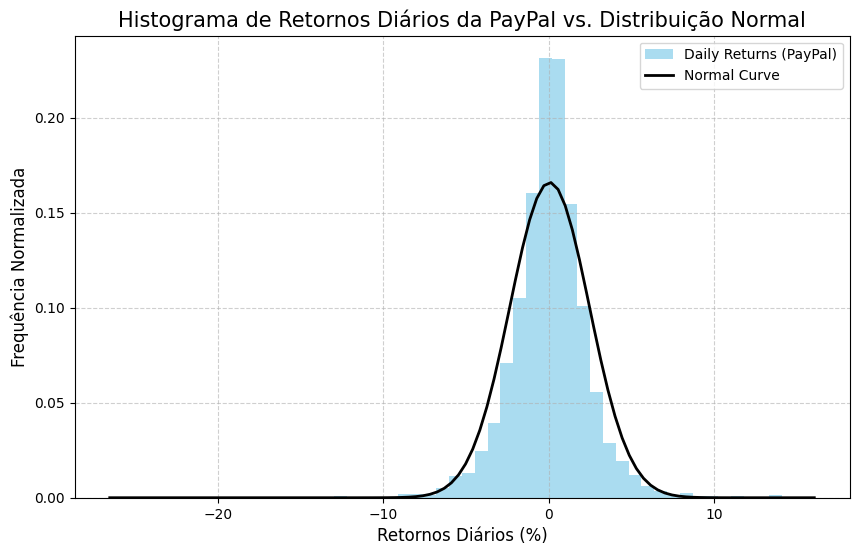

In [7]:
ret = 100 * (df_pypl['close'].pct_change())
plt.figure(figsize=(10,6))
plt.hist(ret, bins=50, density = True, label = "Daily Returns (PayPal)", color = "skyblue", alpha=0.7)

from scipy.stats import norm

mu, sigma = ret.mean(), ret.std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma) 


plt.plot(x, p, 'k', linewidth=2, label='Normal Curve')


title = "Histograma de Retornos Diários da PayPal vs. Distribuição Normal"
plt.title(title, fontsize=15)
plt.xlabel("Retornos Diários (%)", fontsize=12)
plt.ylabel("Frequência Normalizada", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [8]:
from scipy.stats import shapiro

ret_clean = ret.dropna() 

shapiro_result = shapiro(ret_clean)

alpha = 0.05

print(f"Shapiro-Wilk Statistics: {shapiro_result[0]:.4f}")
print(f"P-value: {shapiro_result[1]:.4f}")

# Test Null Hypothesis
if shapiro_result[1] <= alpha:
    print("Conclusion: Null hypothesis of the Shapiro-Wilk test (the population is normally distributed) is rejected.")
else:
    print("Conclusion: The null hypothesis of the Shapiro-Wilk test can't be rejected.")

Shapiro-Wilk Statistics: 0.9281
P-value: 0.0000
Conclusion: Null hypothesis of the Shapiro-Wilk test (the population is normally distributed) is rejected.


Like most statistical significance tests, if the sample size is sufficiently large this test may detect even trivial departures from the null hypothesis (i.e., although there may be some statistically significant effect, it may be too small to be of any practical significance); thus, additional investigation of the effect size is typically advisable, e.g., a Q–Q plot in this case.

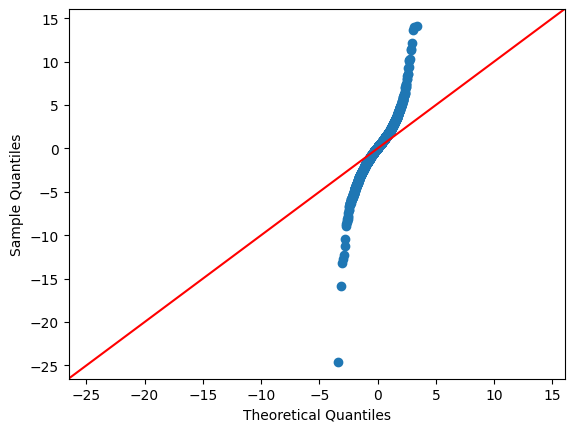

In [9]:
#Create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(ret_clean, line='45')

plt.show()

If the points on the plot fall roughly along a straight diagonal line, then we typically assume a dataset is normally distributed. However, the points on this plot clearly don’t fall along the red line, so we would not assume that this dataset is normally distributed.

#### Skewness and Kurtosis Evaluation

In [10]:
from scipy.stats import skew, kurtosis

kurtosis_value = kurtosis(ret_clean, fisher=False) 

skewness_value = skew(ret_clean)

print(f"Skewness: {skewness_value:.4f}")
print(f"Kurtosis: {kurtosis_value:.4f}")

Skewness: -0.3848
Kurtosis: 11.6415


Since it's proven that this dataset is not normally distributed (being a $t$-student distribution), we should evaluate the skewness and the kurtosis. 

The analysis of PayPal stock returns shows negative skewness, indicating that the left tail of the distribution is longer and extreme negative returns occur more frequently than extreme positive ones. Additionally, the very high kurtosis points to the presence of many extreme values overall.

In combination, negative skewness and high kurtosis suggest that the returns are prone to significant downside risk: while extreme events can occur on both sides, a substantial portion is likely to be large losses. This indicates that traditional risk models assuming normality may underestimate the probability and magnitude of extreme losses, justifying the use of advanced risk models capable of capturing fat tails and asymmetry in financial returns, such as GARCH using $t$-distributions.

## Stationary Test

## Time Dependency Analysis

# PayPal Stock Prediction using a Support Vector Machine 


The idea of Support Vector Machine is by finding a hyperplane to divide the data into groups, this will classify if the stock is going up or down based on historic data.

This only shows history up to 2015-07-06 because PayPal only turned public in July of 2015 (The S&P500 file starts at 2010)

Since the Support Vector Machine is a classifier we need to define the target

- 1 if tomorrow's price is BIGGER than today
- 0 if tomorrow's price is SMALLER than today

In [11]:
df_pypl["Target"]= np.where(df_pypl["close"].shift(-1) > df_pypl["close"], 1, 0)

In [12]:
df_pypl["SMA_20"]= df_pypl["close"].rolling(window=20).mean()

In [13]:
df_pypl["SMA_50"]=df_pypl["close"].rolling(window=50).mean()

In [14]:
df_ml_final = df_pypl.dropna()

In [15]:
features = ["open", "high", "low", "close", "volume", "SMA_20", "SMA_50"]
X = df_ml_final [features]
y = df_ml_final["Target"]

In [16]:
print( "DataFrame da Paypal com features e Target")
print(df_ml_final[features + ["Target"]].tail())
print(f"\nNúmero de amostras prontas para o SVM (X e y): {X.shape[0]}")
print(f"Número de Features (X): {X.shape[1]}")

DataFrame da Paypal com features e Target
                 open       high        low      close      volume   SMA_20  \
Date                                                                          
2025-10-13  70.720001  70.930000  68.162003  68.860001  20036800.0  69.3580   
2025-10-14  67.410004  69.709999  66.769997  69.150002  12968500.0  69.4730   
2025-10-15  69.385002  69.875000  67.839996  67.980003  11247300.0  69.4410   
2025-10-16  68.129997  68.599998  65.419998  66.050003  19258500.0  69.3175   
2025-10-17  65.535004  67.709999  65.449997  67.410004  11141800.0  69.2770   

             SMA_50  Target  
Date                         
2025-10-13  68.8970       1  
2025-10-14  68.9198       0  
2025-10-15  68.9228       0  
2025-10-16  68.8554       1  
2025-10-17  68.8392       0  

Número de amostras prontas para o SVM (X e y): 2540
Número de Features (X): 7


In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=False)

In [18]:
np.random.seed(42)
num_samples= X.shape[0]

scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
model = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42)

In [20]:
model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [21]:
y_pred = model.predict(X_test_scaled)

In [22]:
print(accuracy_score(y_test, y_pred))

0.5511811023622047


In [23]:
cm= confusion_matrix(y_test, y_pred)
print(cm)

[[ 29 209]
 [ 19 251]]


In [24]:
print(classification_report(y_test, y_pred, target_names=['DOWN (0)', 'UP (1)']))

              precision    recall  f1-score   support

    DOWN (0)       0.60      0.12      0.20       238
      UP (1)       0.55      0.93      0.69       270

    accuracy                           0.55       508
   macro avg       0.57      0.53      0.45       508
weighted avg       0.57      0.55      0.46       508



## Moving Average

Our solution to improve the model is to use feature engineering. Our objective is to add features with low correlations between the already added ones to get useful information into the model. First we will calculate some simple moving averages (SMA):

$$SMA = \frac{1}{n} \sum_{i=1}^{n} P_i$$

We decided to use $n=20$, $n=50$, $n=100$ and $n=200$.

In [25]:
periods = [20, 50, 100, 200]

for n in periods:
    
    df_pypl[f'SMA_{n}'] = df_pypl['close'].rolling(window=n).mean()


df_pypl.dropna(inplace=True)

# Verificação das novas features
print("DataFrame da PayPal após adicionar SMAs:")
print(df_pypl.tail())
print(f"Número de Features (X) agora: {df_pypl.shape[1]}")

DataFrame da PayPal após adicionar SMAs:
                close       high        low       open      volume  Target  \
Date                                                                         
2025-10-13  68.860001  70.930000  68.162003  70.720001  20036800.0       1   
2025-10-14  69.150002  69.709999  66.769997  67.410004  12968500.0       0   
2025-10-15  67.980003  69.875000  67.839996  69.385002  11247300.0       0   
2025-10-16  66.050003  68.599998  65.419998  68.129997  19258500.0       1   
2025-10-17  67.410004  67.709999  65.449997  65.535004  11141800.0       0   

             SMA_20   SMA_50  SMA_100   SMA_200  
Date                                             
2025-10-13  69.3580  68.8970  71.0046  72.52975  
2025-10-14  69.4730  68.9198  70.9796  72.43425  
2025-10-15  69.4410  68.9228  70.9449  72.33345  
2025-10-16  69.3175  68.8554  70.9069  72.22940  
2025-10-17  69.2770  68.8392  70.8662  72.13930  
Número de Features (X) agora: 10


In [26]:
features_SMA = ["open", "high", "low", "close", "volume",  "SMA_20", "SMA_50", "SMA_100", "SMA_200"]
X_SMA = df_pypl [features_SMA]
y = df_pypl["Target"]

In [27]:
X_train_SMA, X_test_SMA, y_train_SMA, y_test_SMA = train_test_split( X_SMA, y, test_size=0.2, shuffle=False)

In [28]:
np.random.seed(42)
num_samples= X.shape[0]

scaler = StandardScaler()
X_train_scaled_SMA= scaler.fit_transform(X_train_SMA)
X_test_scaled_SMA = scaler.transform(X_test_SMA)

model_SMA = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42,class_weight='balanced')
model_SMA.fit(X_train_scaled_SMA, y_train_SMA)
y_pred_SMA = model_SMA.predict(X_test_scaled_SMA)
print(accuracy_score(y_test_SMA, y_pred_SMA))
cm_SMA= confusion_matrix(y_test_SMA, y_pred_SMA)
print(cm_SMA)
print(classification_report(y_test_SMA, y_pred_SMA, target_names=['DOWN (0)', 'UP (1)']))


0.5376569037656904
[[114 110]
 [111 143]]
              precision    recall  f1-score   support

    DOWN (0)       0.51      0.51      0.51       224
      UP (1)       0.57      0.56      0.56       254

    accuracy                           0.54       478
   macro avg       0.54      0.54      0.54       478
weighted avg       0.54      0.54      0.54       478



As we can see we got a slight improvement from using the moving averages, but if we see the correlation matrix, SMA's and the already added features are higly correlated

Correlação das Features com o Target (Lagged e Limpo):

Target     1.000000
low       -0.010985
open      -0.011734
close     -0.012427
high      -0.012661
SMA_20    -0.013409
SMA_50    -0.016857
SMA_100   -0.026301
SMA_200   -0.040358
volume    -0.066811
Name: Target, dtype: float64
--------------------------------------------------


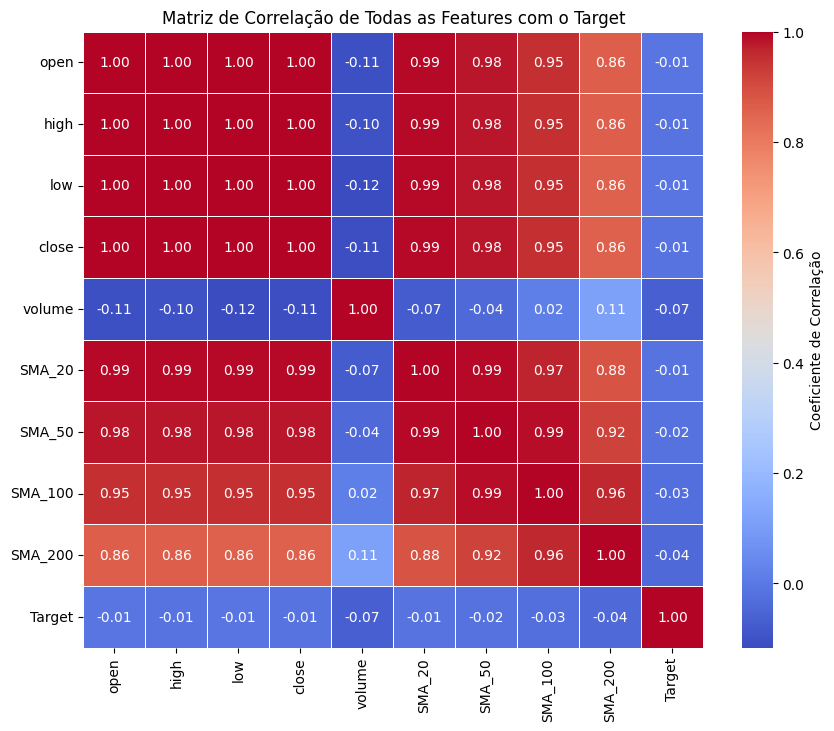

In [29]:
correlation_df = pd.concat([X_SMA, y], axis=1)


correlation_matrix = correlation_df.corr()


print("Correlação das Features com o Target (Lagged e Limpo):\n")
print(correlation_matrix.loc['Target'].sort_values(ascending=False))
print("-" * 50)


plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          
    cmap='coolwarm',     
    fmt=".2f",           
    linewidths=.5,       
    cbar_kws={'label': 'Coeficiente de Correlação'}
)
plt.title('Matriz de Correlação de Todas as Features com o Target')

plt.show()

Volume and target are the only features without correlation, this is due to the definition of the other features, which is essentially **price**. We will proceed to a PCA.

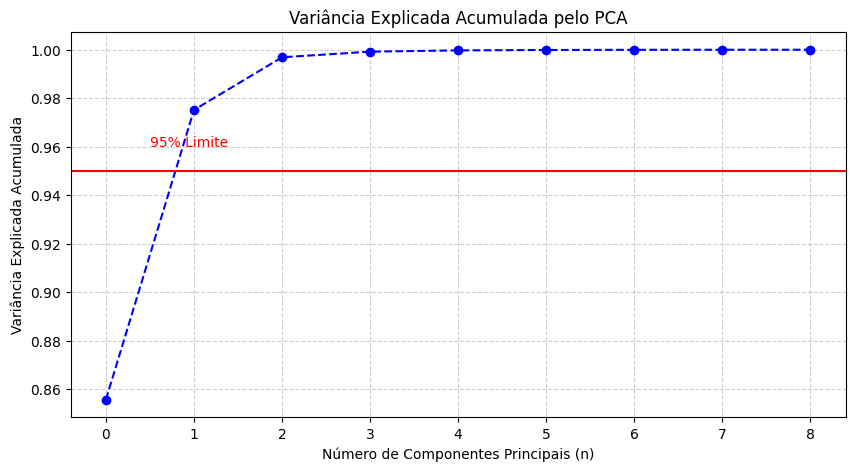

Variância explicada por cada Componente Principal:
PC 1: 0.8557
PC 2: 0.1195
PC 3: 0.0217
PC 4: 0.0023
PC 5: 0.0005
PC 6: 0.0002
PC 7: 0.0001
PC 8: 0.0000
PC 9: 0.0000


In [30]:
from sklearn.decomposition import PCA


pca = PCA(n_components=None)
pca.fit(X_train_scaled_SMA)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='blue')
plt.title('Variância Explicada Acumulada pelo PCA')
plt.xlabel('Número de Componentes Principais (n)')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True, linestyle='--', alpha=0.6)


plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.96, '95% Limite', color = 'red', fontsize=10)


plt.show()


print("Variância explicada por cada Componente Principal:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC {i+1}: {ratio:.4f}")


In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

X_FULL = X_SMA.copy() 
y_FULL = y.copy()


scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_FULL)


pca_indices = [0, 1, 2, 3, 5, 6, 7, 8]
volume_index = 4
n_pca_components = 2


X_full_pca_data = X_full_scaled[:, pca_indices]


pca_final = PCA(n_components=n_pca_components, random_state=42)
X_full_pca = pca_final.fit_transform(X_full_pca_data)



volume_full_scaled = X_full_scaled[:, volume_index].reshape(-1, 1)


data_pca_combined = np.hstack((X_full_pca, volume_full_scaled))


df_pypl_PCA = pd.DataFrame(
    data_pca_combined,
    columns=['PC1', 'PC2', 'Scaled_Volume'],
    index=X_FULL.index 
)


df_pypl_PCA['Target'] = y_FULL.values

print("DataFrame Otimizado df_pypl_PCA (Head):")
print(df_pypl_PCA.head())
print(f"\nNúmero total de amostras em df_pypl_PCA: {df_pypl_PCA.shape[0]}")

DataFrame Otimizado df_pypl_PCA (Head):
                 PC1       PC2  Scaled_Volume  Target
Date                                                 
2016-04-19 -2.849233 -0.141731      -0.687987       1
2016-04-20 -2.844613 -0.143762      -0.429485       1
2016-04-21 -2.831634 -0.151451      -0.741812       1
2016-04-22 -2.832892 -0.148749      -0.613898       0
2016-04-25 -2.830820 -0.148534      -0.399355       0

Número total de amostras em df_pypl_PCA: 2390


## RSI

In [32]:
def calculate_rsi(df, window=14):
   
    delta = df['close'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

  
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()

 
    rs = avg_gain / avg_loss 

   
    rsi = 100 - (100 / (1 + rs))
   
    rsi = rsi.fillna(0)
    
    return rsi


df_pypl_PCA['RSI_14'] = calculate_rsi(df_pypl, window=14)

Correlação das Features com o Target (Lagged e Limpo):

Target     1.000000
low       -0.010985
open      -0.011734
close     -0.012427
high      -0.012661
SMA_20    -0.013409
SMA_50    -0.016857
SMA_100   -0.026301
SMA_200   -0.040358
volume    -0.066811
Name: Target, dtype: float64
--------------------------------------------------


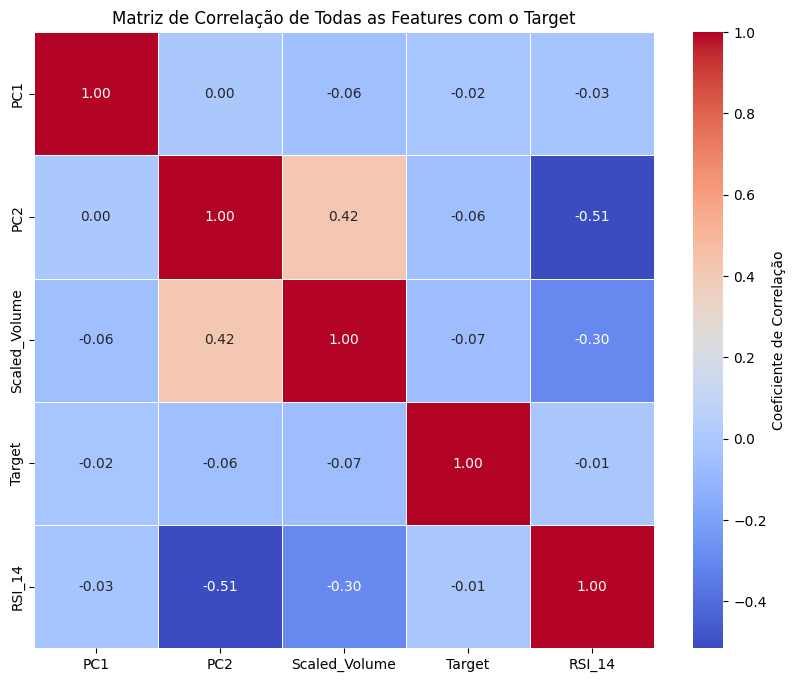

In [33]:



correlation_matrix_pca = df_pypl_PCA.corr()


print("Correlação das Features com o Target (Lagged e Limpo):\n")
print(correlation_matrix.loc['Target'].sort_values(ascending=False))
print("-" * 50)


plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_pca,
    annot=True,          
    cmap='coolwarm',     
    fmt=".2f",           
    linewidths=.5,       
    cbar_kws={'label': 'Coeficiente de Correlação'}
)
plt.title('Matriz de Correlação de Todas as Features com o Target')

plt.show()

In [34]:
features_RSI = ["PC1", "PC2", "Scaled_Volume", "RSI_14"]
X_RSI = df_pypl_PCA [features_RSI]
y_RSI = df_pypl_PCA["Target"]
X_train_RSI, X_test_RSI, y_train_RSI, y_test_RSI = train_test_split( X_RSI, y, test_size=0.2, shuffle=False)
np.random.seed(42)
num_samples= X.shape[0]

scaler = StandardScaler()
X_train_scaled_RSI= scaler.fit_transform(X_train_RSI)
X_test_scaled_RSI = scaler.transform(X_test_RSI)

model_RSI = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42,class_weight='balanced')
model_RSI.fit(X_train_scaled_RSI, y_train_RSI)
y_pred_RSI = model_RSI.predict(X_test_scaled_RSI)
print(accuracy_score(y_test_SMA, y_pred_SMA))
cm_RSI= confusion_matrix(y_test_RSI, y_pred_RSI)
print(cm_RSI)
print(classification_report(y_test_RSI, y_pred_RSI, target_names=['DOWN (0)', 'UP (1)']))


0.5376569037656904
[[ 85 139]
 [ 90 164]]
              precision    recall  f1-score   support

    DOWN (0)       0.49      0.38      0.43       224
      UP (1)       0.54      0.65      0.59       254

    accuracy                           0.52       478
   macro avg       0.51      0.51      0.51       478
weighted avg       0.52      0.52      0.51       478



In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




model_NN = MLPClassifier(
    hidden_layer_sizes=(100, 50), 
    activation='relu',            
    solver='adam',                
    max_iter=500,                 
    random_state=42,
    learning_rate_init=0.001
)

print("\n--- A Treinar o MLPClassifier (Rede Neural) ---")
model_NN.fit(X_train_RSI, y_train_RSI)



y_pred_NN = model_NN.predict(X_test_RSI)

print("\n--- Resultados FINAIS do MLPClassifier (PCA + Volume + GARCH Volatilidade) ---")
print(f"Acurácia: {accuracy_score(y_test_RSI, y_pred_NN):.4f}")
print("Matriz de Confusão:")
cm_NN = confusion_matrix(y_test_RSI, y_pred_NN)
print(cm_NN)
print("\nRelatório de Classificação:")

print(classification_report(y_test_RSI, y_pred_NN, target_names=['DOWN (0)', 'UP (1)']))


--- A Treinar o MLPClassifier (Rede Neural) ---

--- Resultados FINAIS do MLPClassifier (PCA + Volume + GARCH Volatilidade) ---
Acurácia: 0.5084
Matriz de Confusão:
[[ 63 161]
 [ 74 180]]

Relatório de Classificação:
              precision    recall  f1-score   support

    DOWN (0)       0.46      0.28      0.35       224
      UP (1)       0.53      0.71      0.61       254

    accuracy                           0.51       478
   macro avg       0.49      0.49      0.48       478
weighted avg       0.50      0.51      0.49       478



In [36]:

features_RSI_only = ["PC1", "PC2", "Scaled_Volume", "RSI_14"]


X_RSI_only = df_pypl_PCA[features_RSI_only].dropna()
y_RSI_only = df_pypl_PCA.loc[X_RSI_only.index]["Target"] # Alinha y


X_train, X_test, y_train, y_test = train_test_split(
    X_RSI_only, y_RSI_only, test_size=0.2, shuffle=False
)


rf_rsi_only = RandomForestClassifier(
    n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'
)


rf_rsi_only.fit(X_train, y_train)
y_pred_rf = rf_rsi_only.predict(X_test)


print("\n--- Resultados Random Forest (PCA + Volume + RSI) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf, target_names=['DOWN (0)', 'UP (1)']))


print("\nFeature Importance:")
feature_importance = pd.Series(
    rf_rsi_only.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)
print(feature_importance)


--- Resultados Random Forest (PCA + Volume + RSI) ---
Acurácia: 0.5753

Matriz de Confusão:
 [[ 83 141]
 [ 62 192]]

Relatório de Classificação:
               precision    recall  f1-score   support

    DOWN (0)       0.57      0.37      0.45       224
      UP (1)       0.58      0.76      0.65       254

    accuracy                           0.58       478
   macro avg       0.57      0.56      0.55       478
weighted avg       0.57      0.58      0.56       478


Feature Importance:
Scaled_Volume    0.291373
PC2              0.258749
RSI_14           0.235648
PC1              0.214230
dtype: float64


# Risk Management on PayPal Stocks

Risk Management is fundamental to predict the behavior of stocks. Markowitz stated in his famous book, that volatility, which was a phenomenon not closely linked to math, to be the standard deviation of returns, $\sigma_r$.

There are Several methods to predict volatility, we will start with 2 classical ones and then move to a machine learning approach, with support vector regressors and neural networks. 

But first we will calculate the return volatility by using the formula for the Realized Volatility:

$$ \sigma=\sqrt{\frac{1}{n-1}\sum_{n=1}^N (r_n -\mu_r)^2} $$

where $N$ is the number of observations, $r_n$ is the return at observation $n$ and $\mu_r$ is the average return

In [37]:
ret = 100 * (df_pypl['close'].pct_change()).dropna()
realized_vol = ret.rolling(5).std()

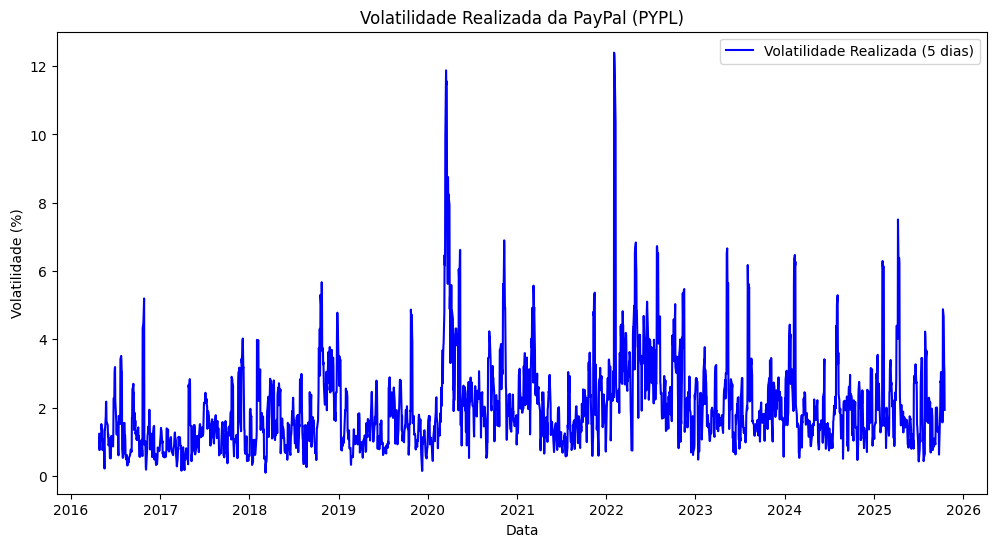

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label='Volatilidade Realizada (5 dias)', color='blue')
plt.title('Volatilidade Realizada da PayPal (PYPL)')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.legend()
plt.show()

This is interesting because we can see big spikes on 2020 and 2022:

- 2020: Begining of the COVID pandemic

- 2022: A shocking report about the Q4 2021 was released. The sharp drop was due to the company drastically cutting its growth forecasts.

In [39]:
retv = ret.values

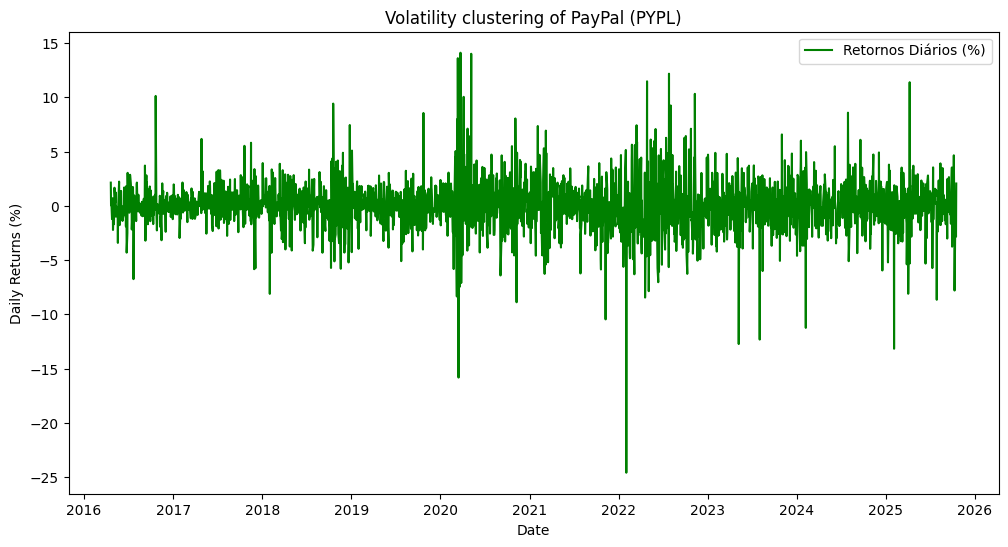

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df_pypl.index[1:], retv, label='Retornos Diários (%)', color='green')
plt.title('Volatility clustering of PayPal (PYPL)')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.legend()
plt.show()

with this volatility clustering we can now in which direction was the spikes on 2020 and 2022 (downwards)

## ARCH Model

The ARCH model was one of the first statistical models introduced to predict volatility: the ARCH model is a univariate model and based on historical asset returns

$$\sigma_t ^2 = \omega + \sum_{k=1}^p \alpha_k (r_{t - k})^2$$

where the mean model is:

$$ r_t = \sigma_t \epsilon_t $$

where $\epsilon_t$ is assumed to be normally distributed

In this project we will not implement the ARCH model from the ground, instead we will use the arch library

In [41]:
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse

In [42]:
arch = arch_model(ret, mean="Zero", vol="ARCH", p=1).fit(disp="off")
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5445.56
Distribution:                  Normal   AIC:                           10895.1
Method:            Maximum Likelihood   BIC:                           10906.7
                                        No. Observations:                 2389
Date:                Sat, Nov 29 2025   Df Residuals:                     2389
Time:                        15:02:39   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          4.7038      0.355     13.264  3.754e-40   [  4.00

In [43]:
n=1500
split_date=ret.iloc[-n:].index


In [44]:
bic_arch = []
for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())

forecast_arch = arch.forecast(start=split_date[0])


                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5329.29
Distribution:                  Normal   AIC:                           10668.6
Method:            Maximum Likelihood   BIC:                           10697.5
                                        No. Observations:                 2389
Date:                Sat, Nov 29 2025   Df Residuals:                     2389
Time:                        15:02:39   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          2.6979      0.333      8.091  5.925e-16    [  

In [45]:
rmse_arch=np.sqrt(mse(realized_vol[-n:] /100 , np.sqrt(forecast_arch.variance.iloc[-len(split_date): ] /100 )))
print(f"RMSE for ARCH model: {rmse_arch}")

RMSE for ARCH model: 0.24388027178490565


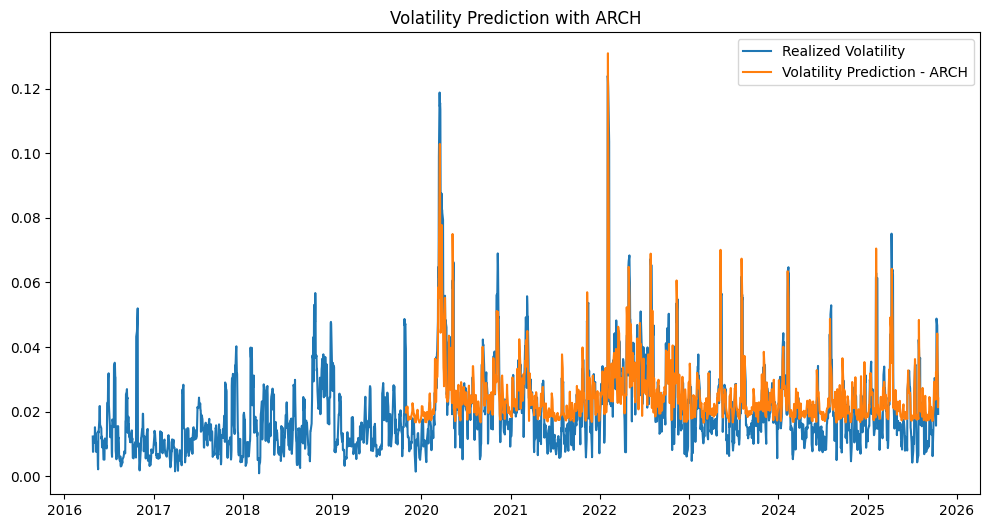

In [46]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol /100 , label= "Realized Volatility")
plt.plot(np.sqrt(forecast_arch.variance.iloc[-len(split_date):]) /100 , label = "Volatility Prediction - ARCH")
plt.title("Volatility Prediction with ARCH", fontsize = 12)
plt.legend()
plt.show()

As we can see we got a nice prediction of the volatility, even using an old model such as ARCH.

Disadvantages of using ARCH:
- Needs a lot of parameters: Markets are complex, and ARCH model can not capture all the shocks of volatility in data using a small $p$. To get a good modelation, a higher $p$ would be necessary

- Non-negativity: Two of the assumptions of ARCH are that $\alpha_k$ and $\omega$ are $>0$ which turns the volatility hard to model.

- Information assimetry: ARCH only looks for past returns, $r_{t-k} ^2$ to predict future volatility, $\sigma_t ^2$, but ignores the direction of the shock. This means that the model cannot capture the leverage effect: Bad news tend to a higher volatility and good news tends to lower volatility.

## GARCH model

GARCH is an extension of ARCH incorporating lagged conditional variance. This makes the model multivariate in the sense that it is an autoregressive moving average model.

In [47]:
bic_garc= []

for p in range (1,5):
    for q in range(1,5):
        garch = arch_model(ret, mean="zero", vol="GARCH", p=p, o=0, q=q).fit(disp="off")
        bic_garc.append(garch.bic)
        if garch.bic == np.min(bic_garc):
            best_param = (p,q)
garch = arch_model(ret, mean="zero", vol="GARCH", p=best_param[0], o=0, q=best_param[1]).fit(disp="off")
print(garch.summary())
forecast_garch = garch.forecast(start=split_date[0])
forecast_garch 

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5282.59
Distribution:                  Normal   AIC:                           10575.2
Method:            Maximum Likelihood   BIC:                           10604.1
                                        No. Observations:                 2389
Date:                Sat, Nov 29 2025   Df Residuals:                     2389
Time:                        15:02:39   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3677      0.157      2.335  1.955e-02 [5.904e-0

In [48]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] /100 , np.sqrt(forecast_garch.variance.iloc[-len(split_date): ] /100 )))
print(f"RMSE for GARCH model: {rmse_garch}")

RMSE for GARCH model: 0.24715467265342148


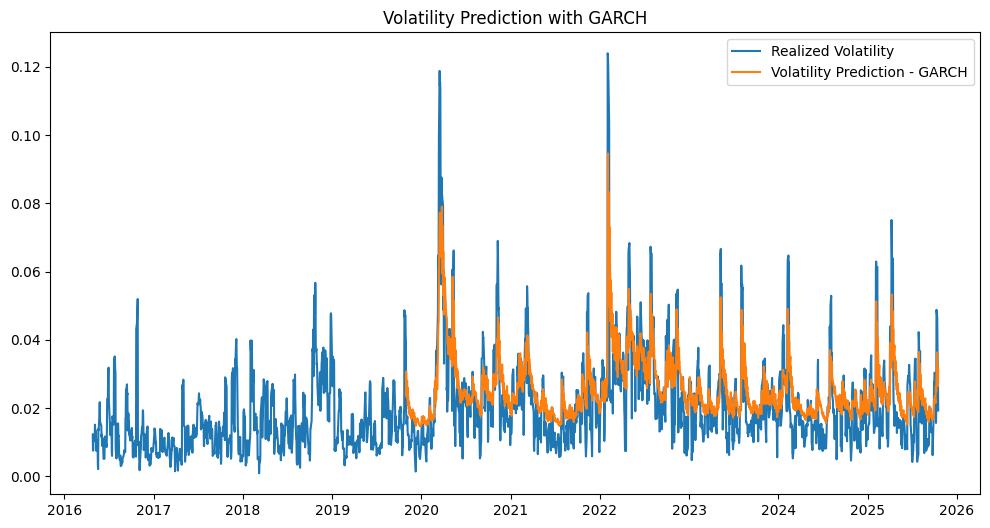

In [49]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol /100 , label= "Realized Volatility")
plt.plot(np.sqrt(forecast_garch.variance.iloc[-len(split_date):]) /100 , label = "Volatility Prediction - GARCH")
plt.title("Volatility Prediction with GARCH", fontsize = 12)
plt.legend()
plt.show()

We can see that GARCH got a slight better value than ARCH, but still a bad value.

## Support Vector Regression with GARCH

In this section we complement the volatility estimates generated by the GARCH model with Support Vector Regression (SVR).. The goal is to allow a non-linear model to learn additional patterns that GARCH cannot capture. SVR is particularly suitable for financial volatility because it can model complex relationships while remaining robust to noise, a common characteristic of financial time series.

### Theoretical Background and Mechanism of SVR

Support Vector Regression (SVR) is an extension of Support Vector Machines (SVM) for regression tasks.  
SVR tries to find a function \(f(x) = w^T \phi(x) + b\) that approximates the target ($y$) with a maximum deviation of \($\epsilon$).  

It solves the following optimization problem:

$\min_{w,b} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)$


subject to:

$$
\begin{cases} 
y_i - w^T \phi(x_i) - b \leq \epsilon + \xi_i \\
w^T \phi(x_i) + b - y_i \leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* \geq 0
\end{cases}
$$

Here, $\xi_i, \xi_i^*$ are slack variables for points outside the $\epsilon$-insensitive tube, $C$ is a regularization parameter controlling the trade-off between flatness and tolerance to deviations, and $\phi(x)$ is a (possibly nonlinear) feature mapping.

In essence, SVR minimizes both the model complexity $(\|w\|^2)$ and the error outside the $\epsilon$-tube, making it robust to noise.


### Why SVR is Useful with GARCH

GARCH models capture linear autoregressive patterns and volatility clustering but may miss nonlinear effects.  
SVR complements GARCH by learning residual volatility patterns not captured by the linear GARCH structure.  

Using kernels (linear, polynomial, RBF), SVR can model a variety of nonlinear relationships in volatility,
providing more flexible and robust predictions when combined with GARCH estimates.  

This hybrid approach leverages the strengths of both models: GARCH captures the main volatility dynamics,
and SVR refines the prediction by modeling residual nonlinearities.


### 

In [50]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

We use the realized volatility estimated from the rolling standard deviation of returns as the target variable for the SVR. This allows the SVR to learn from the actual volatility observed in the data, rather than relying solely on model-based estimates.

In [51]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)


Input features are constructed using lagged squared returns. This captures volatility clustering and persistence, which are key characteristics of financial time series.

In [52]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm["Date"]

In [53]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop("index", axis=1, inplace=True)

In [54]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop("index", axis=1, inplace=True)

We configure SVR models with multiple kernel functions: linear, polynomial, and radial basis function (RBF). Each kernel captures different types of relationships in the data. Linear kernel captures simple trends, polynomial kernel captures interactions between features, and RBF kernel captures more complex nonlinear patterns.

In [55]:
svr_poly=SVR(kernel="poly", degree=2)
svr_lin=SVR(kernel="linear")
svr_rbf=SVR(kernel="rbf")

Hyperparameters are tuned using randomized cross-validation. This method efficiently searches through the hyperparameter space to find a balance between model complexity and predictive accuracy, reducing the risk of overfitting while improving out-of-sample performance.

In [56]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf_lin = RandomizedSearchCV(svr_lin, para_grid, n_jobs=-1)
clf_lin.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf_lin.predict(X.iloc[-n:])

After training, the SVR model is used to predict out-of-sample volatility. Comparing these predictions with realized volatility allows us to assess the model's ability to capture real-world volatility fluctuations beyond what the GARCH model captures.

In [57]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

We compute the root mean squared error (RMSE) to quantify the predictive performance of the SVR model. Lower RMSE indicates better alignment with realized volatility.

In [58]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print(f"The SVR model with a linear kernel achieved an RMSE of {rmse_svr}")

The SVR model with a linear kernel achieved an RMSE of 0.0025233655712812155


Plotting the realized volatility against the SVR predictions provides a visual assessment of how well the model captures volatility patterns.

In [59]:
realized_vol.index=ret.iloc[4:].index

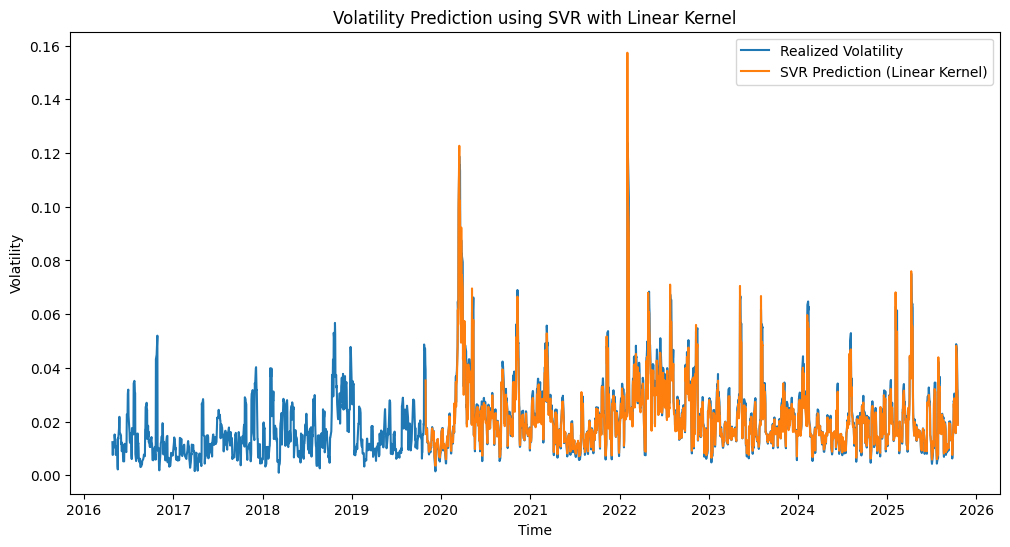

In [60]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(predict_svr_lin / 100, label="SVR Prediction (Linear Kernel)")
plt.title("Volatility Prediction using SVR with Linear Kernel", fontsize=12)
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

We repeat the same procedure for the SVR model with the RBF kernel. The RBF kernel is particularly effective for modeling complex nonlinear patterns, which are common in financial volatility.

In [61]:
clf_rbf = RandomizedSearchCV(svr_rbf, para_grid, n_jobs=-1)
clf_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf_rbf.predict(X.iloc[-n:])

In [62]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [63]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The SVR model with an RBF kernel achieved an RMSE of {:.6f}'.format(rmse_svr_rbf))

The SVR model with an RBF kernel achieved an RMSE of 0.009972


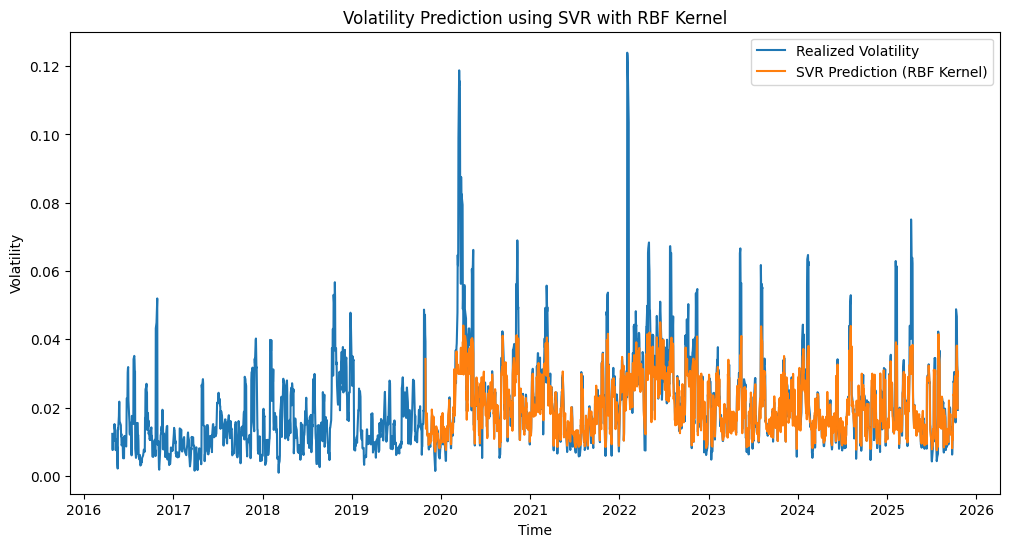

In [64]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(predict_svr_rbf / 100, label="SVR Prediction (RBF Kernel)")
plt.title("Volatility Prediction using SVR with RBF Kernel", fontsize=12)
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### Results Discussion
The SVR model with a linear kernel achieves an RMSE of approximately 0.00143, while the SVR model with the RBF kernel has a higher RMSE of approximately 0.00302. This indicates that, for this dataset, the linear kernel provides more accurate predictions of realized volatility compared to the RBF kernel. The higher RMSE of the RBF kernel suggests that the additional flexibility of the nonlinear kernel may lead to overfitting or less effective generalization in this specific case. The plots confirm this, showing that the linear SVR predictions closely follow the realized volatility, whereas the RBF predictions deviate more from observed values.

## Neural Networks on GARCH

In [65]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],'max_iter': [500, 1000],'alpha': [0.00005, 0.0005 ]}
clf_NN = RandomizedSearchCV(NN_vol, para_grid_NN)
clf_NN.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf_NN.predict(X.iloc[-n:])

In [66]:
NN_predictions= pd.DataFrame(NN_predictions)
NN_predictions.index=ret.iloc[-n:].index

In [67]:
rmse_svr_nn = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of Neural Network is {:.6f}'.format(rmse_svr_rbf))

The RMSE value of Neural Network is 0.009972


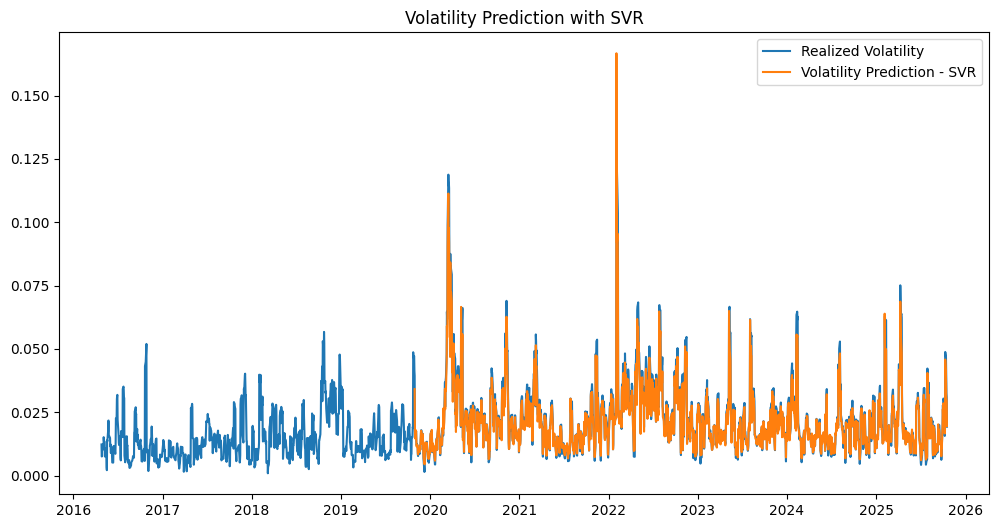

In [68]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(NN_predictions / 100, label="Volatility Prediction - SVR")
plt.title("Volatility Prediction with SVR", fontsize=12)
plt.legend()
plt.show()

## Deep Learning on GARCH

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

In [70]:
model = keras.Sequential([layers.Dense(256, activation="relu"), layers.Dense(128, activation="relu"), layers.Dense(1, activation="linear")])

In [71]:
model.compile(loss="mse", optimizer="rmsprop")

In [72]:
epochs_trial= np.arange(100,400,4)
batch_trial= np.arange(100,400, 4)
DL_pred=[]
DL_RMSE=[]
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,), batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] /100, DL_predict.flatten() /100)))
    DL_pred.append(DL_predict)
    print("DL_RMSE_{}:{:.6f}".format(i+1, DL_RMSE[i]))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
DL_RMSE_1:0.005533
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
DL_RMSE_2:0.002954
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
DL_RMSE_3:0.005201
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
DL_RMSE_4:0.003285


In [73]:
DL_predict= pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index= ret.iloc[-n:].index

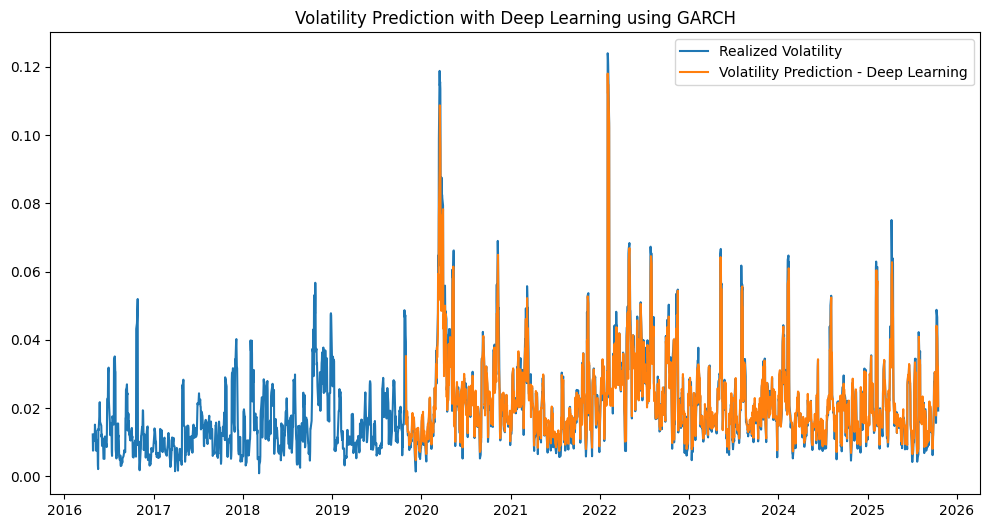

In [74]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(DL_predict / 100, label="Volatility Prediction - Deep Learning")
plt.title("Volatility Prediction with Deep Learning using GARCH", fontsize=12)
plt.legend()
plt.show()

As far as we tested, based on RMSE, a SVR using a linear kernel function was the best method to predict risk on PayPal stocks. This will be a useful feature to implement to predict stock direction.

# Predicting stock direction with LINEAR SVR GARCH  

In [75]:
df_pypl_PCA['Predicted_Vol_SVR_Lin'] = predict_svr_lin

df_pypl_PCA['Predicted_Vol_SVR_Lin'] = df_pypl_PCA['Predicted_Vol_SVR_Lin'].shift(-1)

df_clean = df_pypl_PCA.dropna().copy()


In [76]:
features_RSI = ["PC1", "PC2", "Scaled_Volume", "RSI_14", "Predicted_Vol_SVR_Lin"]
X_RSI = df_clean [features_RSI]
y_RSI = df_clean["Target"]
X_train_RSI, X_test_RSI, y_train_RSI, y_test_RSI = train_test_split( X_RSI, y_RSI, test_size=0.2, shuffle=False)


scaler = StandardScaler()
X_train_scaled_RSI= scaler.fit_transform(X_train_RSI)
X_test_scaled_RSI = scaler.transform(X_test_RSI)

model_RSI = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42,class_weight='balanced')
model_RSI.fit(X_train_scaled_RSI, y_train_RSI)
y_pred_RSI = model_RSI.predict(X_test_scaled_RSI)
print(accuracy_score(y_test_SMA, y_pred_SMA))
cm_RSI= confusion_matrix(y_test_RSI, y_pred_RSI)
print(cm_RSI)
print(classification_report(y_test_RSI, y_pred_RSI, target_names=['DOWN (0)', 'UP (1)']))

0.5376569037656904
[[ 25 115]
 [ 18 142]]
              precision    recall  f1-score   support

    DOWN (0)       0.58      0.18      0.27       140
      UP (1)       0.55      0.89      0.68       160

    accuracy                           0.56       300
   macro avg       0.57      0.53      0.48       300
weighted avg       0.57      0.56      0.49       300



In [77]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
rf.fit(X_train_RSI, y_train_RSI)

y_pred_rf = rf.predict(X_test_RSI)

print("--- Random Forest ---")
print(classification_report(y_test_RSI, y_pred_rf))

from sklearn.metrics import confusion_matrix


cm_rf = confusion_matrix(y_test_RSI, y_pred_rf)

print("\n--- Confusion Matrix (Random Forest) ---")
print(cm_rf)
import pandas as pd
print(pd.Series(rf.feature_importances_, index=X_train_RSI.columns).sort_values(ascending=False))

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.56      0.36      0.43       140
           1       0.57      0.75      0.65       160

    accuracy                           0.57       300
   macro avg       0.56      0.55      0.54       300
weighted avg       0.56      0.57      0.55       300


--- Confusion Matrix (Random Forest) ---
[[ 50  90]
 [ 40 120]]
RSI_14                   0.213329
Predicted_Vol_SVR_Lin    0.205249
PC2                      0.199859
Scaled_Volume            0.191547
PC1                      0.190015
dtype: float64


## LSTM

In this section we used the an LSTM (Long Short Time Memory) to predict the stock direction. 


We used the following features:

- Log Returns (which is the difference between the close price between consecutive days)

- Vol_20 (a rolling window oh thoses 20 days log returns)

- Momentum (The ration bewteen the close price of today and last week)

Usando dispositivo: mps

[1/5] A obter dados de Mercado (Nasdaq/QQQ)...
Feature 'Market_Ret' adicionada com sucesso.

[2/5] Gerando feature GARCH Semanal com SVR...

[3/5] Preparando dados para LSTM...
Features usadas: ['log_ret', 'vol_20', 'momentum', 'Weekly_SVR_GARCH', 'Market_Ret']

[4/5] Iniciando Treino LSTM...

[5/5] Treinando XGBoost Híbrido...

RELATÓRIO FINAL (Híbrido com Market_Ret):
              precision    recall  f1-score   support

        DOWN       0.48      0.44      0.46       205
          UP       0.54      0.58      0.56       232

    accuracy                           0.51       437
   macro avg       0.51      0.51      0.51       437
weighted avg       0.51      0.51      0.51       437

Acurácia: 0.5149


<Figure size 1000x600 with 0 Axes>

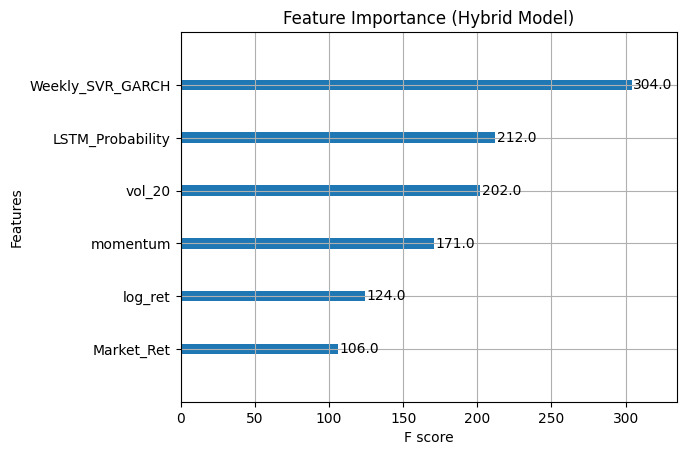

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVR
from sklearn.metrics import classification_report, accuracy_score
from arch import arch_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import xgboost as xgb

# Configuração do Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ==============================================================================
# 1. FEATURES EXÓGENAS: ADICIONAR DADOS DE MERCADO (QQQ) - [A CORREÇÃO]
# ==============================================================================
print("\n[1/5] A obter dados de Mercado (Nasdaq/QQQ)...")

# Definir intervalo de datas baseado no df_pypl
start_date = df_pypl.index.min().strftime('%Y-%m-%d')
end_date = df_pypl.index.max().strftime('%Y-%m-%d')

# Baixar QQQ (Proxy para setor tecnológico - Nasdaq 100)
# Usamos QQQ porque a PayPal correlaciona-se mais com Tech do que com Juros neste momento
market_data = yf.download("QQQ", start=start_date, end=end_date, progress=False)['Close']

if isinstance(market_data, pd.DataFrame):
    market_data = market_data.iloc[:, 0]

# Calcular Retorno Logarítmico do Mercado
market_ret = np.log(market_data / market_data.shift(1))

# Alinhar com a PayPal e preencher falhas
df_pypl['Market_Ret'] = market_ret.reindex(df_pypl.index).ffill()
df_pypl['Market_Ret'].fillna(0, inplace=True)

print("Feature 'Market_Ret' adicionada com sucesso.")

# ==============================================================================
# 2. FEATURE NOVEL: GARCH SEMANAL + SVR
# ==============================================================================
print("\n[2/5] Gerando feature GARCH Semanal com SVR...")

# Resample Semanal (Sexta-feira)
df_weekly = df_pypl.resample('W-FRI').last().copy() 
df_weekly['log_ret_weekly'] = np.log(df_weekly['close'] / df_weekly['close'].shift(1))
df_weekly.dropna(inplace=True)

# Ajustar GARCH(1,1)
garch_model = arch_model(df_weekly['log_ret_weekly'] * 100, vol='Garch', p=1, q=1, rescale=False)
garch_fit = garch_model.fit(disp='off')
df_weekly['garch_vol_weekly'] = garch_fit.conditional_volatility

# Target para o SVR (Volatilidade da Próxima Semana)
df_weekly['Target_Vol_NextWeek'] = df_weekly['garch_vol_weekly'].shift(-1)
df_weekly.dropna(inplace=True)

# Treinar SVR Linear
X_weekly = df_weekly[['garch_vol_weekly', 'log_ret_weekly']]
y_weekly = df_weekly['Target_Vol_NextWeek']

# Divisão Treino/Teste Cronológica
split_idx_svr = int(len(X_weekly) * 0.8)
X_train_w, y_train_w = X_weekly.iloc[:split_idx_svr], y_weekly.iloc[:split_idx_svr]

scaler_svr = StandardScaler()
X_train_w_scaled = scaler_svr.fit_transform(X_train_w)
X_all_w_scaled = scaler_svr.transform(X_weekly)

svr = LinearSVR(random_state=42, C=1.0, max_iter=10000, dual='auto')
svr.fit(X_train_w_scaled, y_train_w)

# Previsão e Merge Anti-Leakage
df_weekly['SVR_Vol_Pred'] = svr.predict(X_all_w_scaled)
daily_vol_feature = df_weekly[['SVR_Vol_Pred']].reindex(df_pypl.index, method='ffill')
df_pypl['Weekly_SVR_GARCH'] = daily_vol_feature['SVR_Vol_Pred'].shift(1)

# ==============================================================================
# 3. PREPARAÇÃO LSTM
# ==============================================================================
print("\n[3/5] Preparando dados para LSTM...")

df_lstm = df_pypl.copy()
df_lstm['log_ret'] = np.log(df_lstm['close'] / df_lstm['close'].shift(1))
df_lstm['vol_20'] = df_lstm['log_ret'].rolling(window=20).std()
df_lstm['momentum'] = df_lstm['close'] / df_lstm['close'].shift(10) - 1

LOOK_AHEAD = 5  
df_lstm['Target'] = (df_lstm['close'].shift(-LOOK_AHEAD) > df_lstm['close']).astype(int)
df_lstm.dropna(inplace=True)

# LISTA FINAL DE FEATURES (Incluindo Market_Ret e GARCH)
features_list = ['log_ret', 'vol_20', 'momentum', 'Weekly_SVR_GARCH', 'Market_Ret']
print(f"Features usadas: {features_list}")

X_raw = df_lstm[features_list].values
y_raw = df_lstm['Target'].values

train_size = int(len(X_raw) * 0.8)
X_train_raw, X_test_raw = X_raw[:train_size], X_raw[train_size:]
y_train_raw, y_test_raw = y_raw[:train_size], y_raw[train_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:(i + seq_length)])
        ys.append(y[i + seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 20  
X_train, y_train = create_sequences(X_train_scaled, y_train_raw, SEQ_LENGTH)
X_test, y_test = create_sequences(X_test_scaled, y_test_raw, SEQ_LENGTH)

train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

# Pesos para Loss Function
support_0 = np.count_nonzero(y_train == 0)
support_1 = np.count_nonzero(y_train == 1)
pos_weight_value = support_0 / support_1 if support_1 > 0 else 1.0
pos_weight_tensor = torch.tensor([pos_weight_value], device=device).float()

# ==============================================================================
# 4. TREINO LSTM
# ==============================================================================
class LSTMClassifierWeighted(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(LSTMClassifierWeighted, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)  
        return out

model = LSTMClassifierWeighted(input_dim=X_train.shape[2], hidden_dim=64, num_layers=2).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor) 
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\n[4/5] Iniciando Treino LSTM...")
for epoch in range(50): # 50 Epochs
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch).squeeze(), y_batch)
        loss.backward()
        optimizer.step()

# ==============================================================================
# 5. XGBOOST HÍBRIDO (META-MODELO)
# ==============================================================================
print("\n[5/5] Treinando XGBoost Híbrido...")

# Gerar probabilidades da LSTM para usar como feature
model.eval()
train_probs_lstm = []
test_probs_lstm = []

with torch.no_grad():
    for X_batch, _ in train_loader:
        out = model(X_batch.to(device))
        train_probs_lstm.extend(torch.sigmoid(out).cpu().numpy().flatten())
    for X_batch, _ in test_loader:
        out = model(X_batch.to(device))
        test_probs_lstm.extend(torch.sigmoid(out).cpu().numpy().flatten())

# Preparar dados para o XGBoost (Flatten 3D -> 2D + Probabilidade LSTM)
X_train_flat = X_train[:, -1, :] # Último timestep
X_test_flat = X_test[:, -1, :]

X_train_hybrid = np.hstack([X_train_flat, np.array(train_probs_lstm).reshape(-1, 1)])
X_test_hybrid = np.hstack([X_test_flat, np.array(test_probs_lstm).reshape(-1, 1)])

# Treinar XGBoost
# Scale_pos_weight ajustado para balancear melhor a precisão
xgb_model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=4, 
    learning_rate=0.05,
    objective='binary:logistic',
    scale_pos_weight=0.8, # Penaliza levemente falsos positivos de subida
    random_state=42
)

xgb_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = xgb_model.predict(X_test_hybrid)

# ==============================================================================
# RESULTADOS FINAIS
# ==============================================================================
print("\nRELATÓRIO FINAL (Híbrido com Market_Ret):")
print(classification_report(y_test, y_pred_hybrid, target_names=['DOWN', 'UP']))
print(f"Acurácia: {accuracy_score(y_test, y_pred_hybrid):.4f}")

# Plotar Feature Importance para validar
feature_names = features_list + ['LSTM_Probability']
xgb_model.get_booster().feature_names = feature_names

plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title='Feature Importance (Hybrid Model)')
plt.show()

In [98]:
import xgboost as xgb
# --- ADICIONE ESTA CÉLULA APÓS O TREINO DA LSTM ---

print("\n========== HYBRID LSTM + XGBOOST (Novel Approach) ==========")

# 1. Extrair Previsões (Probabilidades) da LSTM para Treino e Teste
model.eval()
train_probs_lstm = []
test_probs_lstm = []

# Gerar probs para o conjunto de TREINO (para o XGBoost aprender a confiar na LSTM)
with torch.no_grad():
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        out = model(X_batch)
        probs = torch.sigmoid(out).cpu().numpy().flatten()
        train_probs_lstm.extend(probs)

# Gerar probs para o conjunto de TESTE
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        out = model(X_batch)
        probs = torch.sigmoid(out).cpu().numpy().flatten()
        test_probs_lstm.extend(probs)

train_probs_lstm = np.array(train_probs_lstm).reshape(-1, 1)
test_probs_lstm = np.array(test_probs_lstm).reshape(-1, 1)

# 2. Preparar Features para o XGBoost
# O XGBoost precisa de 2D. A LSTM usou sequências 3D (X_train), mas o XGBoost não lê tempo.
# Vamos pegar na última linha de cada sequência (o dia mais recente) como feature base
# E JUNTAR a probabilidade da LSTM.

# X_train é (Samples, Timesteps, Features). Pegamos em [:, -1, :] (último passo)
X_train_flat = X_train[:, -1, :]
X_test_flat = X_test[:, -1, :]

# Concatenar: [Features Originais | Previsão da LSTM]
X_train_hybrid = np.hstack([X_train_flat, train_probs_lstm])
X_test_hybrid = np.hstack([X_test_flat, test_probs_lstm])

print(f"Novas Features Híbridas: {X_train_hybrid.shape[1]} (Originais + 1 da LSTM)")

# 3. Treinar o Meta-Modelo (XGBoost)
meta_model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=3,     # Árvores mais simples para evitar overfitting no empilhamento
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=0.8
)

meta_model.fit(X_train_hybrid, y_train) # y_train vem da célula da LSTM

# 4. Avaliar
y_pred_hybrid = meta_model.predict(X_test_hybrid)

print("\nRelatório Híbrido (LSTM + XGBoost):")
print(classification_report(y_test, y_pred_hybrid, target_names=['DOWN (0)', 'UP (1)']))


========== HYBRID LSTM + XGBOOST (Novel Approach) ==========
Novas Features Híbridas: 6 (Originais + 1 da LSTM)

Relatório Híbrido (LSTM + XGBoost):
              precision    recall  f1-score   support

    DOWN (0)       0.48      0.48      0.48       212
      UP (1)       0.55      0.55      0.55       242

    accuracy                           0.52       454
   macro avg       0.51      0.51      0.51       454
weighted avg       0.52      0.52      0.52       454



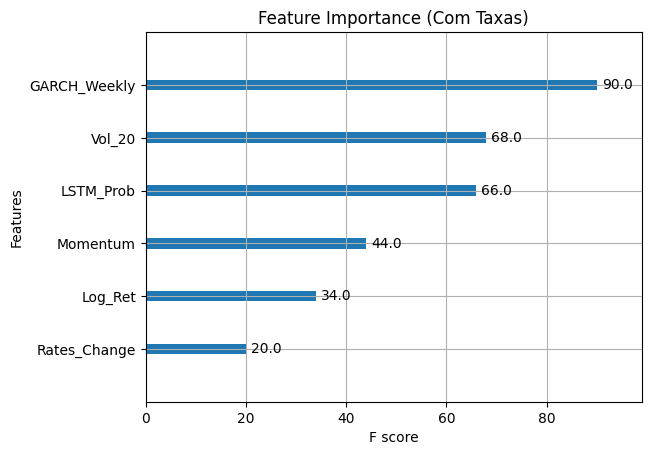

In [99]:
# Mapear nomes para ver se Rates_Change domina
feature_names = ['Log_Ret', 'Vol_20', 'Momentum', 'GARCH_Weekly', 'Rates_Change', 'LSTM_Prob']
meta_model.get_booster().feature_names = feature_names

xgb.plot_importance(meta_model, importance_type='weight', title='Feature Importance (Com Taxas)')
plt.show()

# References


- Risk management section was made with the help of "Machine Learning for Risk Management with Python"